# Visualizing Stability

## Investigating within and across z algorithm stability with SVCCA

**Gregory Way 2018**

Visualizing the stability of compression algorithms across different bottleneck dimensionalities.
This notebook visualizes the output generated from `1.stability-within-z.ipynb` and `2.stability-across-z.ipynb`.

In [26]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(svglite))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(cowplot))

In [27]:
fig_extensions <- c('.png', '.pdf', '.svg')

In [28]:
# Define the dataset to compile results for
svcca_file <- file.path("results", "svcca_within_mean_correlation_weights.tsv.gz")
svcca_df <- readr::read_tsv(svcca_file,
                            col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double()))
print(dim(svcca_df))
head(svcca_df, 2)

[1] 50400     8


seed_1,seed_2,algorithm_1,algorithm_2,svcca_mean_similarity,dataset,z_dim,shuffled
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
165158,451283,pca,pca,0.02189521,TARGET,2,shuffled
165158,451283,pca,ica,0.01873587,TARGET,2,shuffled


In [29]:
table(svcca_df$shuffled)


shuffled   signal 
   25200    25200 

In [30]:
 # Make sure factors are in order
svcca_df$z_dim <- factor(
    svcca_df$z_dim,
    levels = sort(as.numeric(paste(unique(svcca_df$z_dim))))
)

algorithms <- c("pca", "ica", "nmf", "dae", "vae")

svcca_df$algorithm_1 <- factor(
    svcca_df$algorithm_1,
    levels = algorithms
)

svcca_df$algorithm_2 <- factor(
    svcca_df$algorithm_2,
    levels = algorithms
)

recoded <- list("pca" = "PCA",
                "ica" = "ICA",
                "nmf" = "NMF",
                "dae" = "DAE",
                "vae" = "VAE")

svcca_df$algorithm_1 <- svcca_df$algorithm_1 %>%
    dplyr::recode(!!!recoded)

svcca_df$algorithm_2 <- svcca_df$algorithm_2 %>%
    dplyr::recode(!!!recoded)

In [31]:
# Switch the order of the algorithms in the shuffled dataset to
# enable plotting in the lower triangle on the same figure
shuffled_df <- svcca_df %>% dplyr::filter(shuffled == 'shuffled')
signal_df <- svcca_df %>% dplyr::filter(shuffled != 'shuffled')

alg1_shuff <- shuffled_df$algorithm_1
alg2_shuff <- shuffled_df$algorithm_2

shuffled_df$algorithm_1 <- alg2_shuff
shuffled_df$algorithm_2 <- alg1_shuff

svcca_switched_df <- dplyr::bind_rows(signal_df, shuffled_df)

## Visualize stability `across algorithms` with SVCCA

In [32]:
box_theme <- theme(panel.grid.minor = element_line(linewidth = 0.1),
                   panel.grid.major = element_line(linewidth = 0.3),
                   strip.text = element_text(size = 7),
                   strip.background = element_rect(colour = "black",
                                                   fill = "#fdfff4"),
                   axis.text.x = element_text(angle = 90,
                                              size = 3.2),
                   axis.text.y = element_text(size = 6),
                   axis.title = element_text(size = 7),
                   plot.title = element_text(hjust = 0.5,
                                             size = 9))

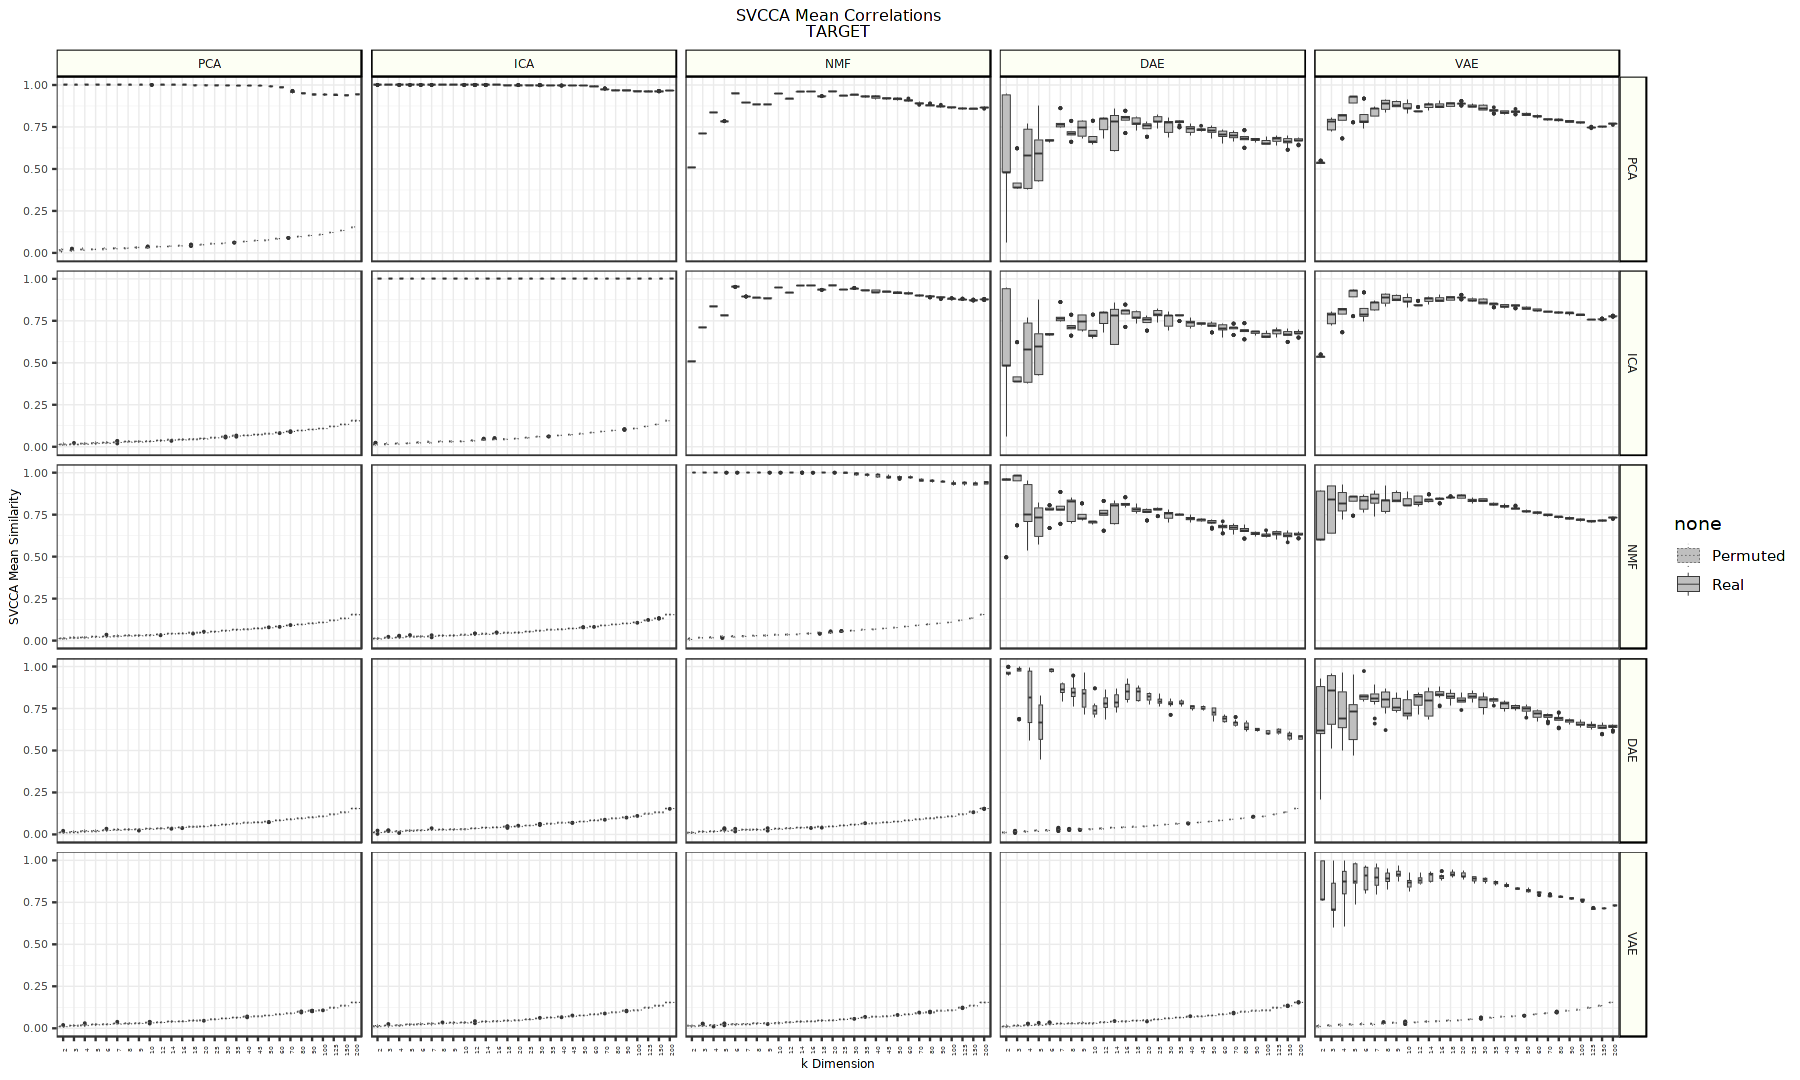

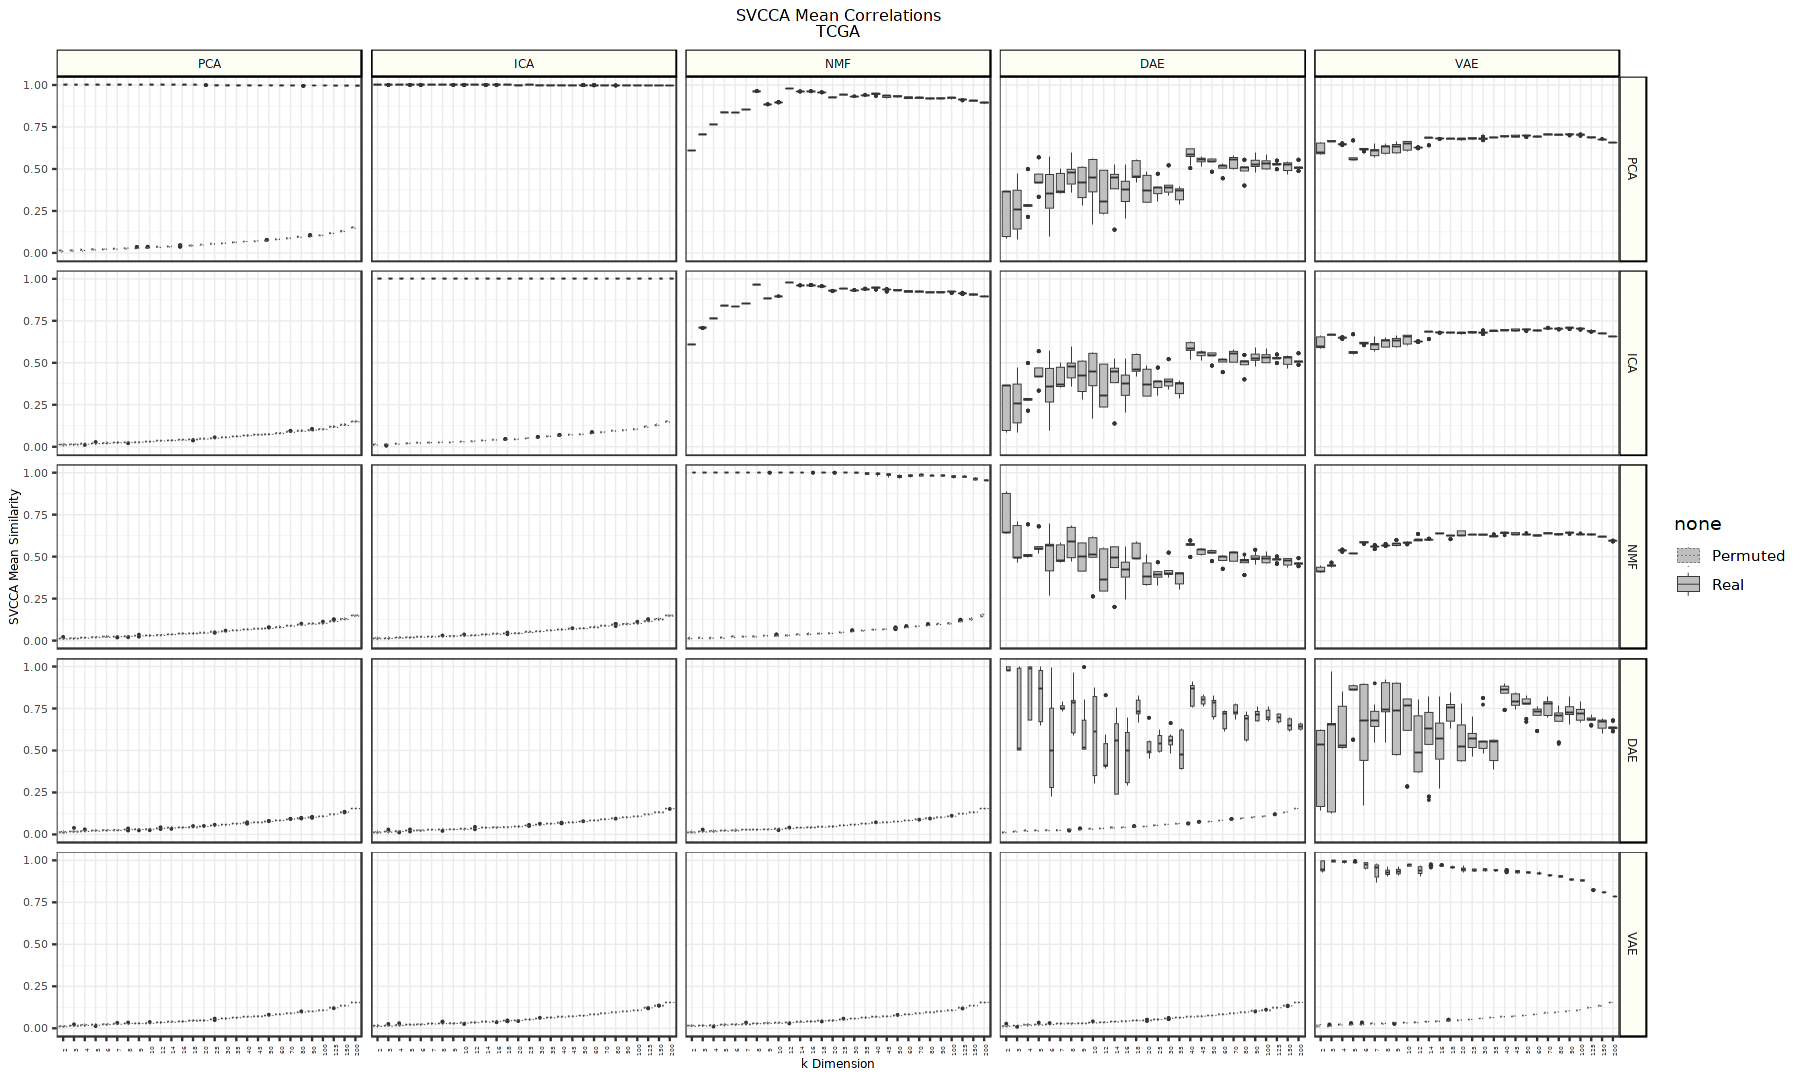

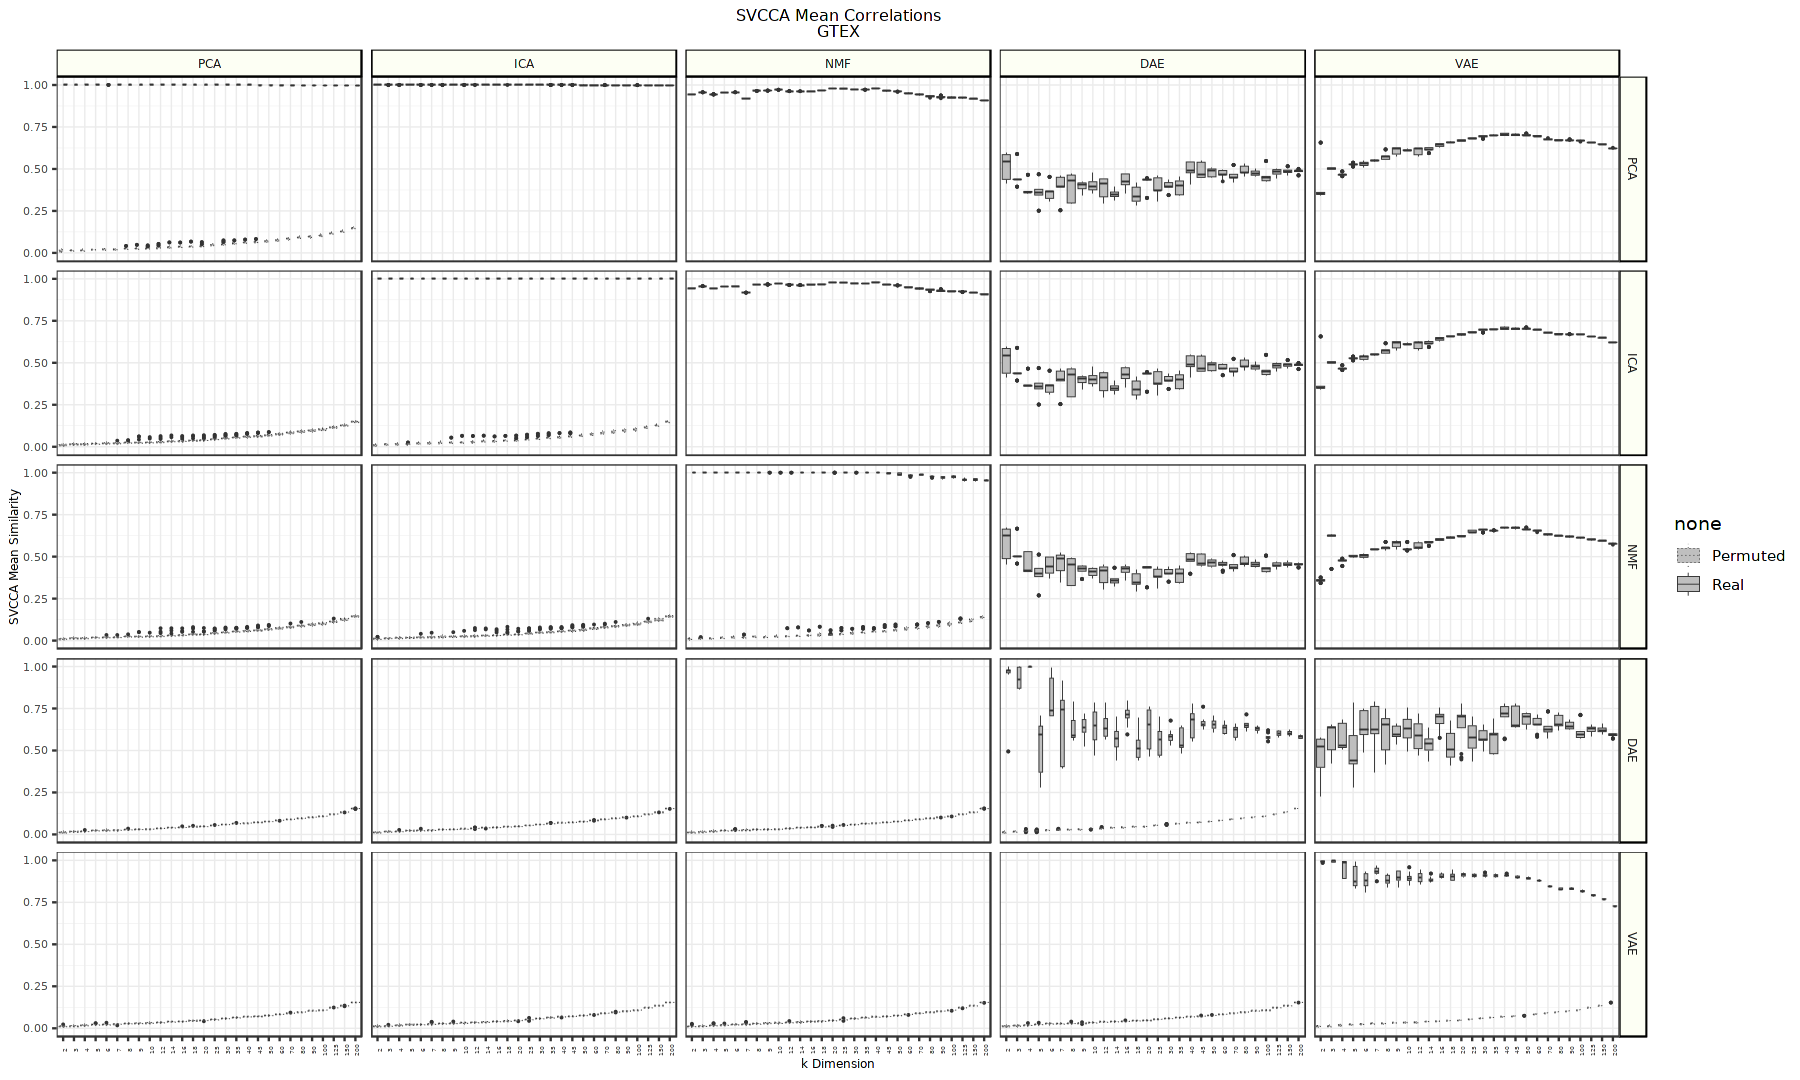

In [33]:
# Visualize across algorithm similarity
options(repr.plot.width = 15, repr.plot.height = 9)


across_algorithm_plots = list()
for(dataset in c("TARGET", "TCGA", "GTEX")) {

    svcca_subset_df <- svcca_switched_df %>%
        dplyr::filter(dataset == !!dataset)

    out_figure <- file.path("figures", paste0("stability_within_z_", dataset))
    plot_title <- paste0("SVCCA Mean Correlations\n", dataset)

    g <- ggplot(svcca_subset_df,
                aes(x = z_dim,
                    y = svcca_mean_similarity,
                    linetype = shuffled)) +
            geom_boxplot(outlier.size = 0.04,
                         lwd = 0.2,
                         fill = 'grey75') +
            facet_grid(algorithm_1 ~ algorithm_2) +
            xlab("k Dimension") +
            ylab("SVCCA Mean Similarity") +
            scale_linetype_manual(name = "Signal:",
                                  values = c("dotted", "solid"),
                                  labels = c("signal" = "Real",
                                             "shuffled" = "Permuted")) +
            ylim(c(0, 1)) +
            ggtitle(plot_title) +
            theme_bw() +
            box_theme +
            guides(linetype = guide_legend("none"))

    across_algorithm_plots[[dataset]] <- g

    for(extension in fig_extensions) {
        gg_file <- paste0(out_figure, extension)
        ggsave(plot = g,
               filename = gg_file,
               height = 120,
               width = 170,
               units = "mm",
               dpi = 500)
    }

    print(g)

}

### Visualize subtractraction of mean signal from mean shuffled

In [34]:
svcca_subset_df <- svcca_df %>%
    dplyr::group_by(algorithm_1, algorithm_2, dataset, z_dim, shuffled) %>%
    dplyr::summarize_at('svcca_mean_similarity', mean)

signal_data = svcca_subset_df %>%
    dplyr::filter(shuffled == 'signal')
shuffled_data = svcca_subset_df %>%
    dplyr::filter(shuffled == 'shuffled')

full_svcca_data = signal_data %>%
    dplyr::full_join(shuffled_data,
                     by = c('algorithm_1', 'algorithm_2', 'dataset', 'z_dim'),
                     suffix = c('_signal', '_shuffled'))

full_svcca_data <- full_svcca_data %>%
    dplyr::mutate(
        svcca_diff = svcca_mean_similarity_signal - svcca_mean_similarity_shuffled
    )

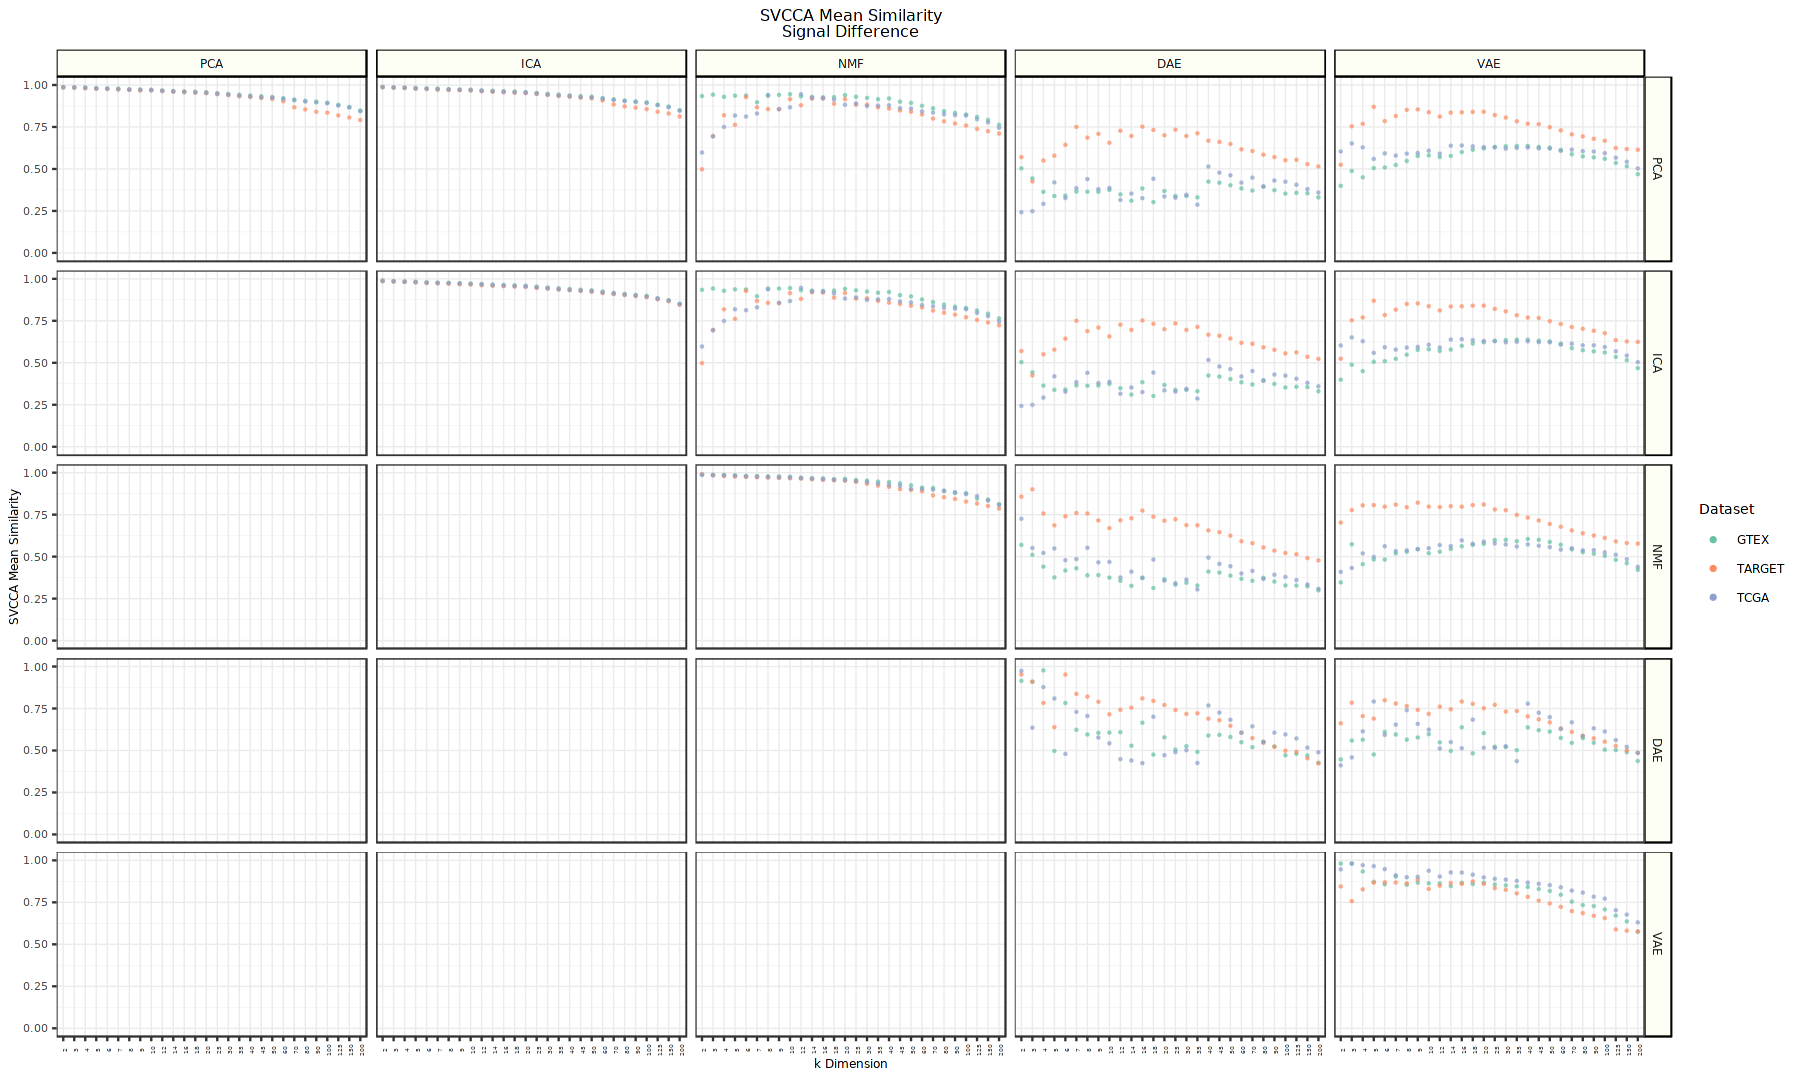

In [35]:
g <- ggplot(full_svcca_data,
            aes(x = z_dim,
                y = svcca_diff,
                color = dataset)) +
    geom_point(alpha = 0.6,
               size = 0.25) +
    facet_grid(algorithm_1 ~ algorithm_2) +
    xlab("k Dimension") +
    ylab("SVCCA Mean Similarity") +
    scale_color_manual(name = "Dataset",
                       values = c("#66c2a5",
                                  "#fc8d62",
                                  "#8da0cb"),
                      labels = c("GTEX" = "GTEX",
                                 "TCGA" = "TCGA",
                                 "TARGET" = "TARGET")) +
    ylim(c(0, 1)) +
    ggtitle(paste0('SVCCA Mean Similarity\nSignal Difference')) +
    theme_bw() +
    box_theme +
    theme(legend.title = element_text(size = 8),
          legend.text = element_text(size = 7)) +
    guides(color = guide_legend(override.aes = list("size" = 1,
                                                    "alpha" = 1)))


across_algorithm_plots[['signal_difference']] <- g

out_figure = file.path("figures", "within_z_signal_difference")

for(extension in fig_extensions) {
    gg_file <- paste0(out_figure, extension)
    ggsave(plot = g,
           filename = gg_file,
           height = 120,
           width = 170,
           units = "mm",
           dpi = 500)
}

print(g)

## Visualize stability `across z` with SVCCA

In [36]:
myPalette <- colorRampPalette(rev(brewer.pal(9, "YlOrRd")))

heat_theme <- theme(panel.grid.minor = element_line(size = 0.1),
                    panel.grid.major = element_line(size = 0.3),
                    axis.text.x = element_text(angle = 90,
                                               size = 3.5),
                    axis.text.y = element_text(size = 3.5),
                    plot.title = element_text(hjust = 0.5,
                                              size = 9),
                    legend.title = element_text(size = 8),
                    legend.text = element_text(size = 7),
                    legend.key.size = unit(1, "lines"),
                    strip.text = element_text(size = 7),
                    strip.background = element_rect(colour = "black",
                                                    fill = "#fdfff4"))

`summarise()` has grouped output by 'dataset', 'algorithm', 'z_dim_a'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'dataset', 'algorithm', 'z_dim_a'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'dataset', 'algorithm', 'z_dim_a'. You can
override using the `.groups` argument.


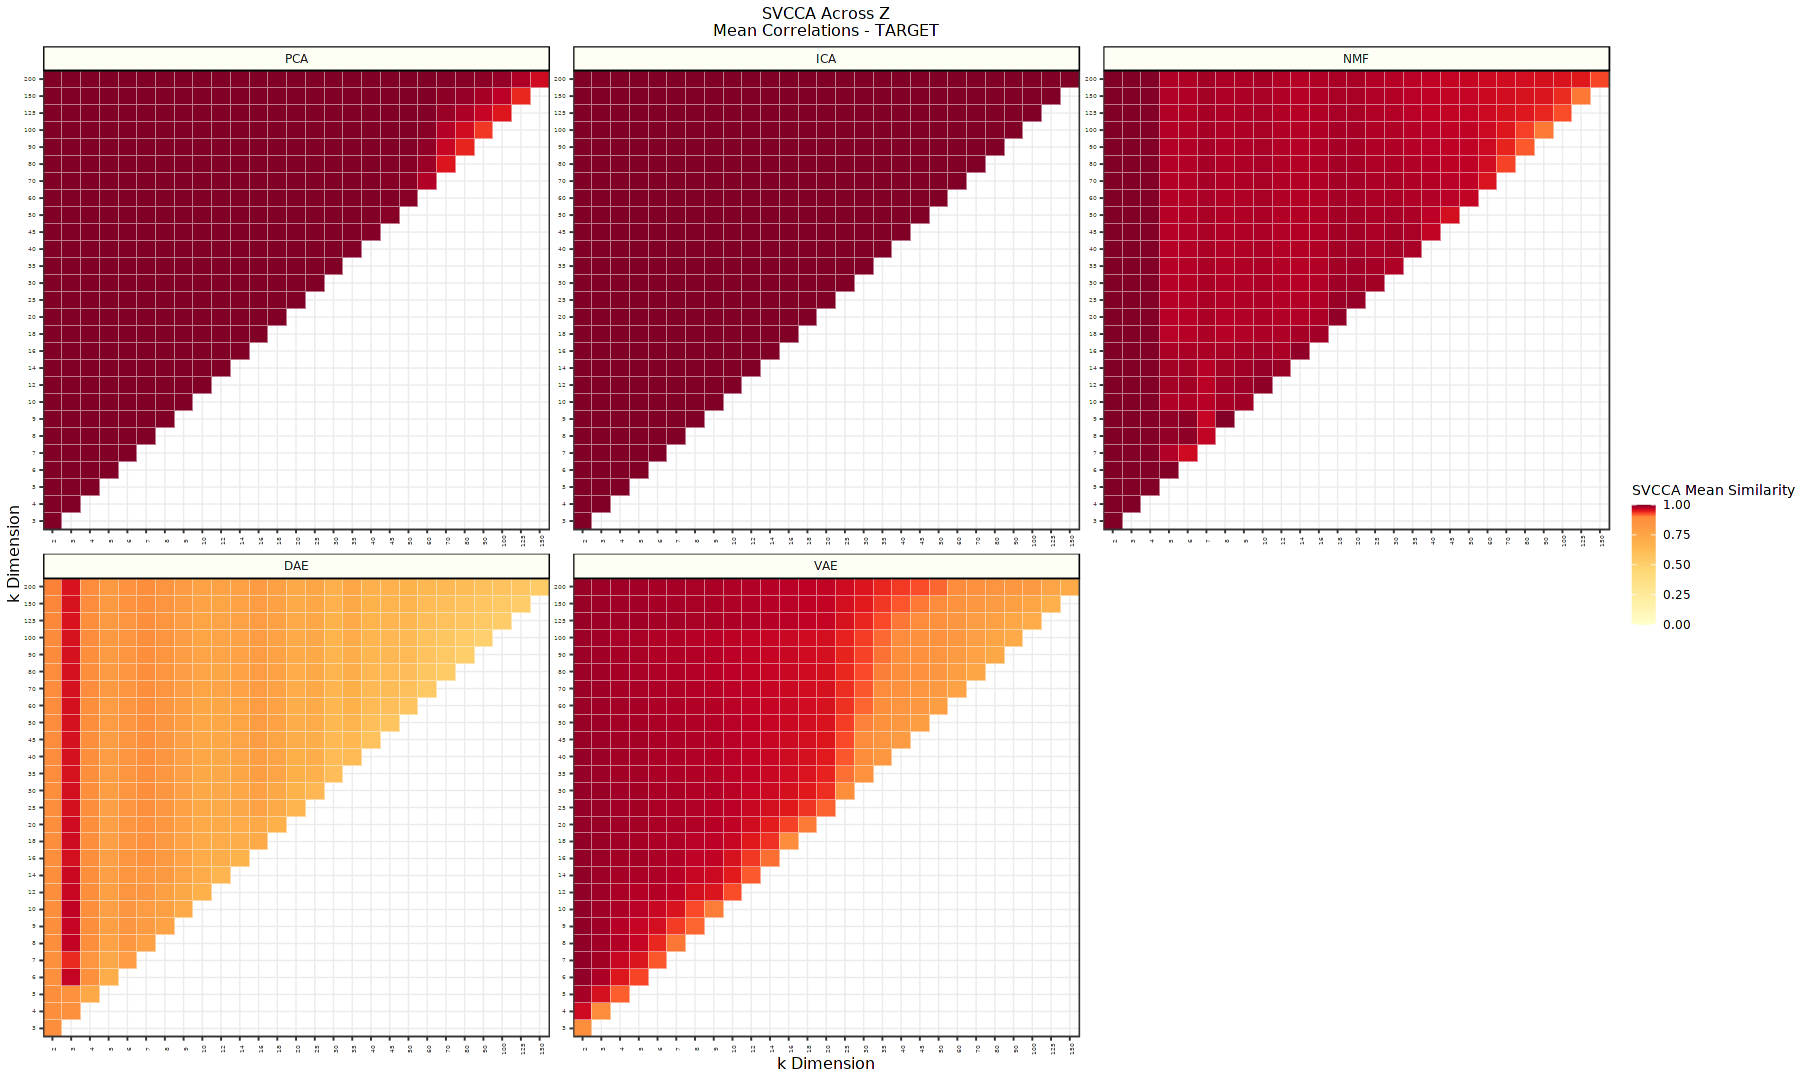

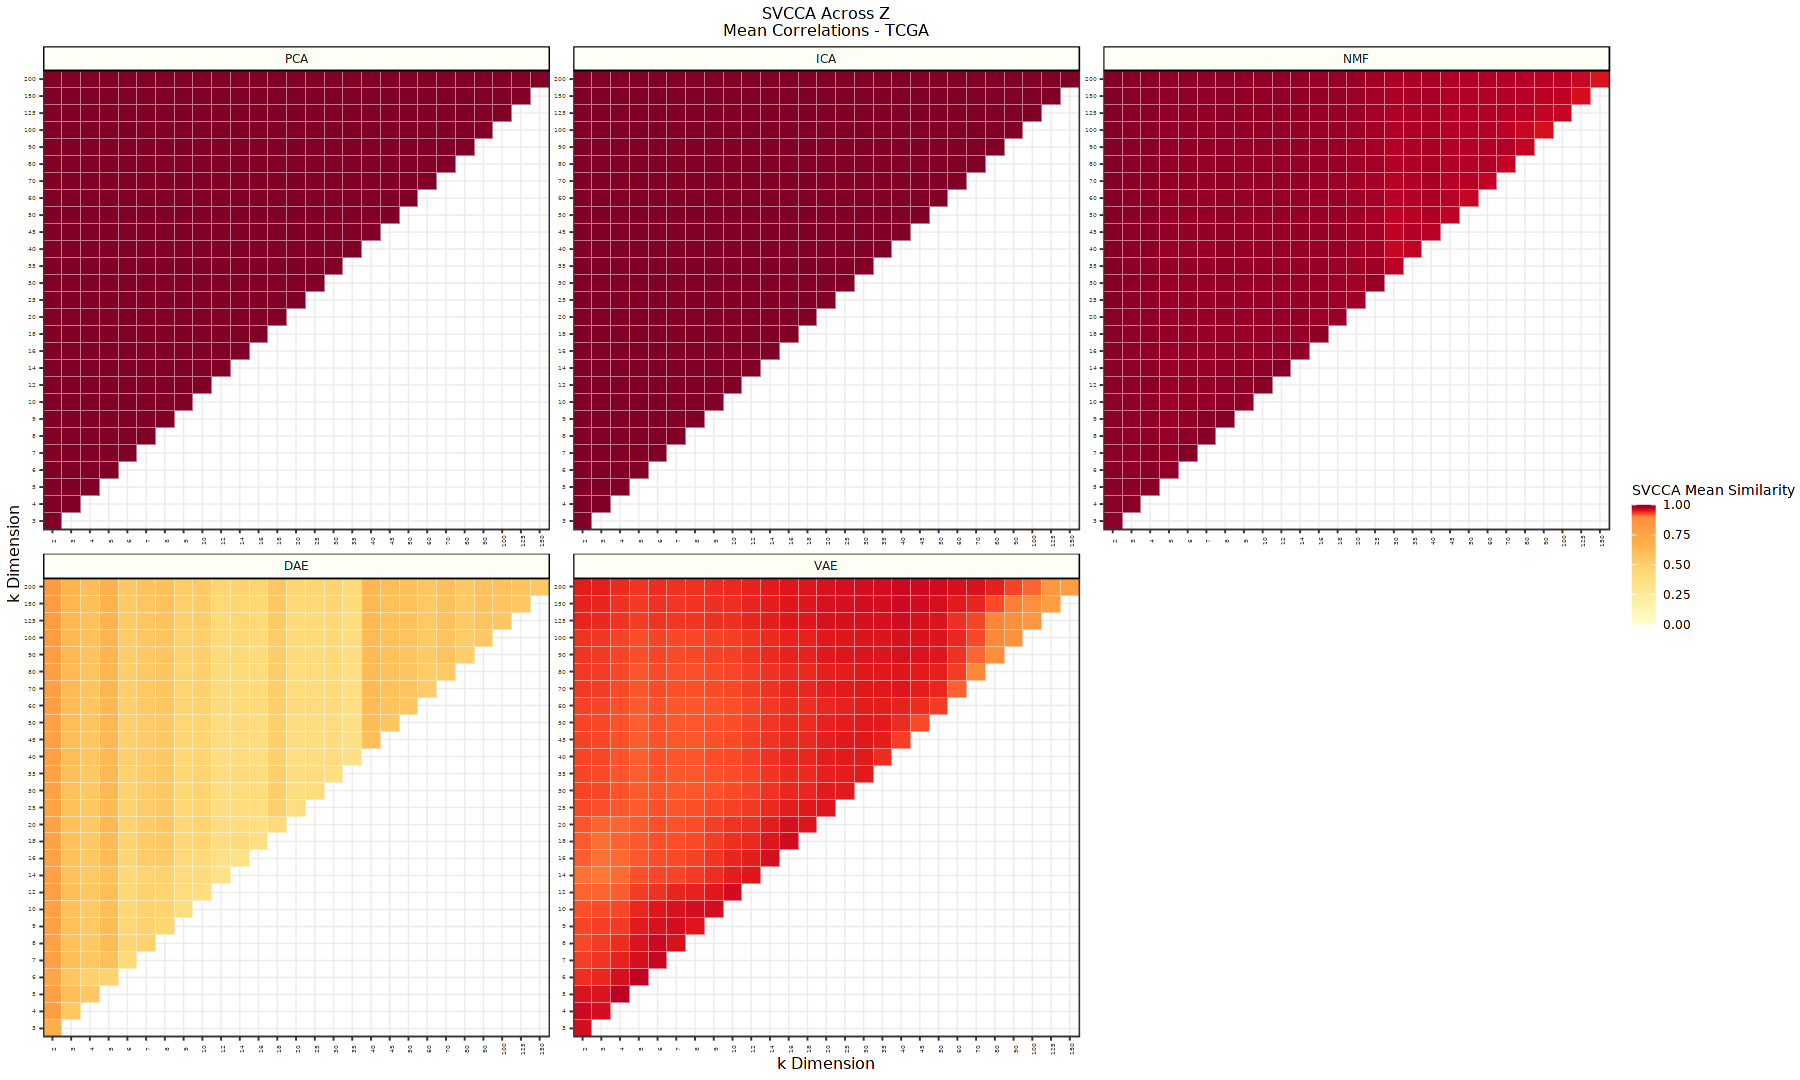

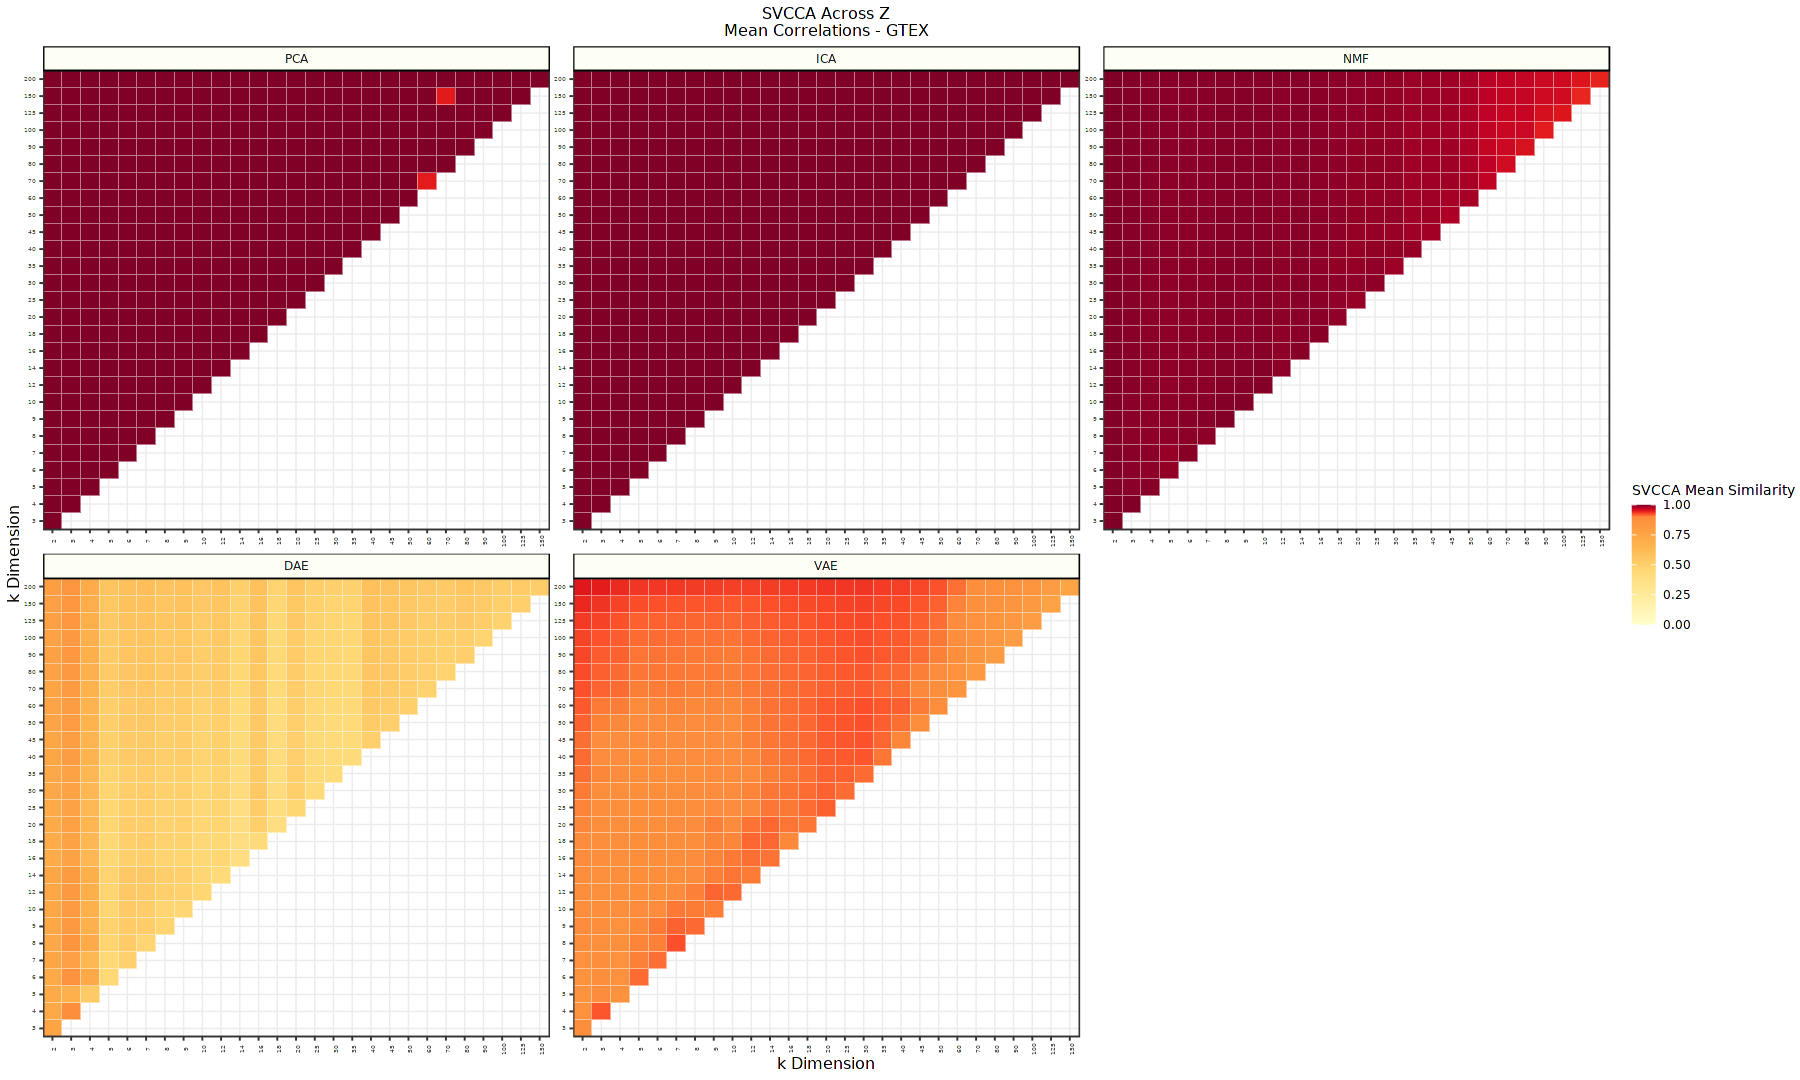

In [37]:
across_dimension_plots = list()
for (dataset in c("TARGET", "TCGA", "GTEX")) {

    # Setup filename
    data_file <- paste0("svcca_across_z_", dataset, "_mean_correlation.tsv.gz")
    data_file <- file.path('results', data_file)
    
    # Load file
    svcca_df <- readr::read_tsv(data_file,
                                col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double(),
                                z_dim_a = readr::col_integer(),
                                z_dim_b = readr::col_integer()))

    # Setup title and output file name
    plot_title <- paste0("SVCCA Across Z\nMean Correlations - ", dataset)
    out_figure <- paste0("stability_across_z_", dataset)
    out_figure <- file.path("figures", out_figure)

    # Make sure factors are in order
    svcca_df$z_dim_a <-
        factor(svcca_df$z_dim_a,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_a))))
               )

    svcca_df$z_dim_b <-
        factor(svcca_df$z_dim_b,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_b))))
               )

    svcca_df$algorithm <- factor(svcca_df$algorithm, levels = algorithms)
    svcca_df$algorithm <- svcca_df$algorithm %>% dplyr::recode(!!!recoded)
    
    svcca_df$svcca_mean_similarity <- as.numeric(paste(svcca_df$svcca_mean_similarity))
    
    # Aggregate over each seed
    svcca_df <- svcca_df %>%
        dplyr::group_by(dataset, algorithm, z_dim_a, z_dim_b) %>%
        dplyr::summarize(svcca_mean = mean(svcca_mean_similarity))

    # Plot and save results
    g <- ggplot(svcca_df, aes(z_dim_a, z_dim_b)) +
            geom_tile(aes(fill = svcca_mean), colour = "white") +
            scale_fill_gradientn(name = "SVCCA Mean Similarity",
                                 colours = myPalette(100),
                                 values = scales::rescale(c(1, 0.99, 0.9)),
                                 limits = c(0, 1)) +
            facet_wrap(~ algorithm, scales = "free") +
            ggtitle(plot_title) +
            theme_bw(base_size = 9) +
            heat_theme +
            xlab("k Dimension") +
            ylab("k Dimension") +
            scale_x_discrete(expand = c(0, 0)) +
            scale_y_discrete(expand = c(0, 0))

    across_dimension_plots[[dataset]] <- g

    for(extension in fig_extensions) {
        gg_file <- paste0(out_figure, extension)
        ggsave(plot = g,
               filename = gg_file,
               height = 100,
               width = 170,
               units = "mm",
               dpi = 500)
    }

    print(g)
}

## Create Figures for Publication

### Main Figure

In [38]:
xmin <- 0.81
xmax <- 0.91
ymin <- 0.1
ymax <- 0.2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


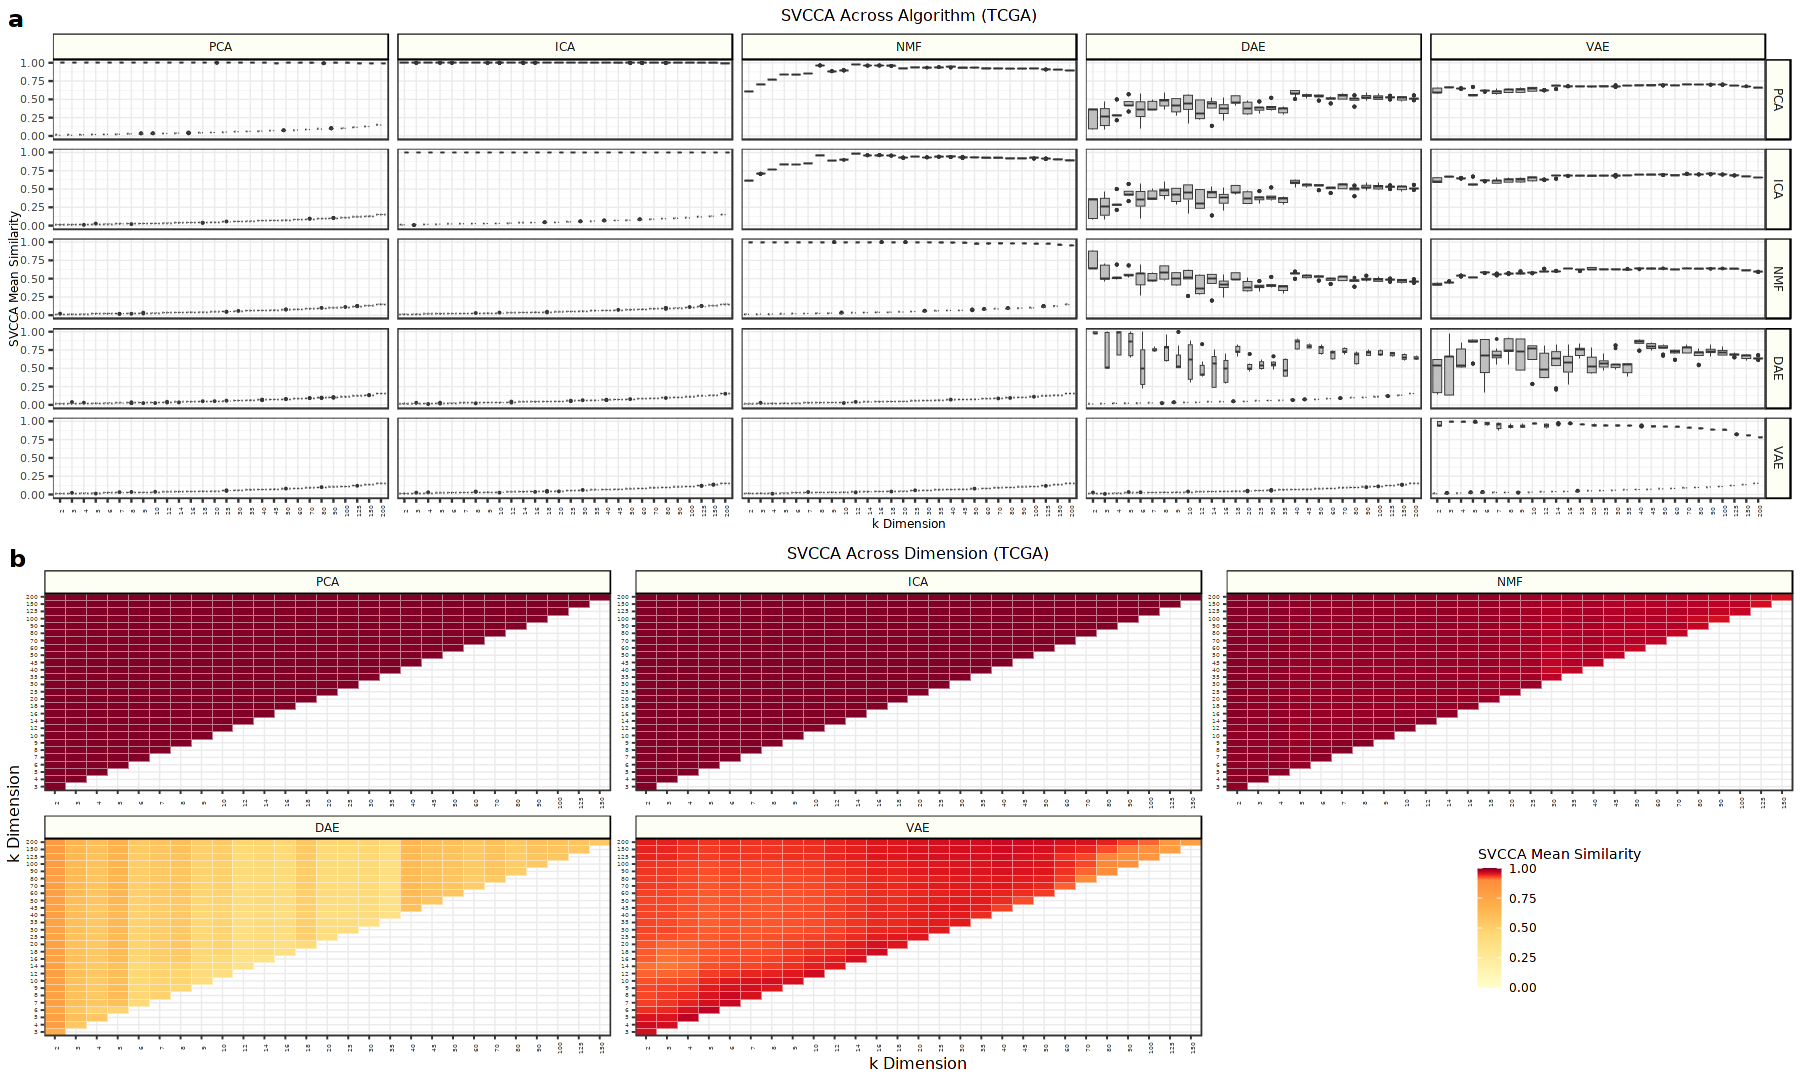

In [39]:
# TCGA is the Main Figure
across_z_legend <- cowplot::get_legend(across_dimension_plots[['TCGA']])

plot_a <- across_algorithm_plots[["TCGA"]] +
            theme(legend.position = 'none') +
            ggtitle(paste0("SVCCA Across Algorithm (TCGA)"))

plot_b <- across_dimension_plots[["TCGA"]] +
            theme(legend.position = 'none') +
            ggtitle(paste0("SVCCA Across Dimension (TCGA)"))

main_plot <- (
    cowplot::plot_grid(
        plot_a,
        plot_b,
        labels = c("a", "b"),
        ncol = 1,
        nrow = 2
    )
)

main_plot <- main_plot + annotation_custom(grob = across_z_legend,
                                           xmin = xmin,
                                           xmax = xmax,
                                           ymin = ymin,
                                           ymax = ymax)

main_plot

In [40]:
for(extension in fig_extensions) {
    fig_file <- paste0("stability_summary_TCGA", extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = main_plot,
                       base_height = 200,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}

### Supplementary Figures

In [41]:
gtex_across_gg <- across_algorithm_plots[["GTEX"]] +
                    theme(legend.position = 'none') +
                    ggtitle(paste0("SVCCA Across Algorithm (GTEX)"))

target_across_gg <- across_algorithm_plots[["TARGET"]] +
                        theme(legend.position = 'none') +
                        ggtitle(paste0("SVCCA Across Algorithm (TARGET)"))

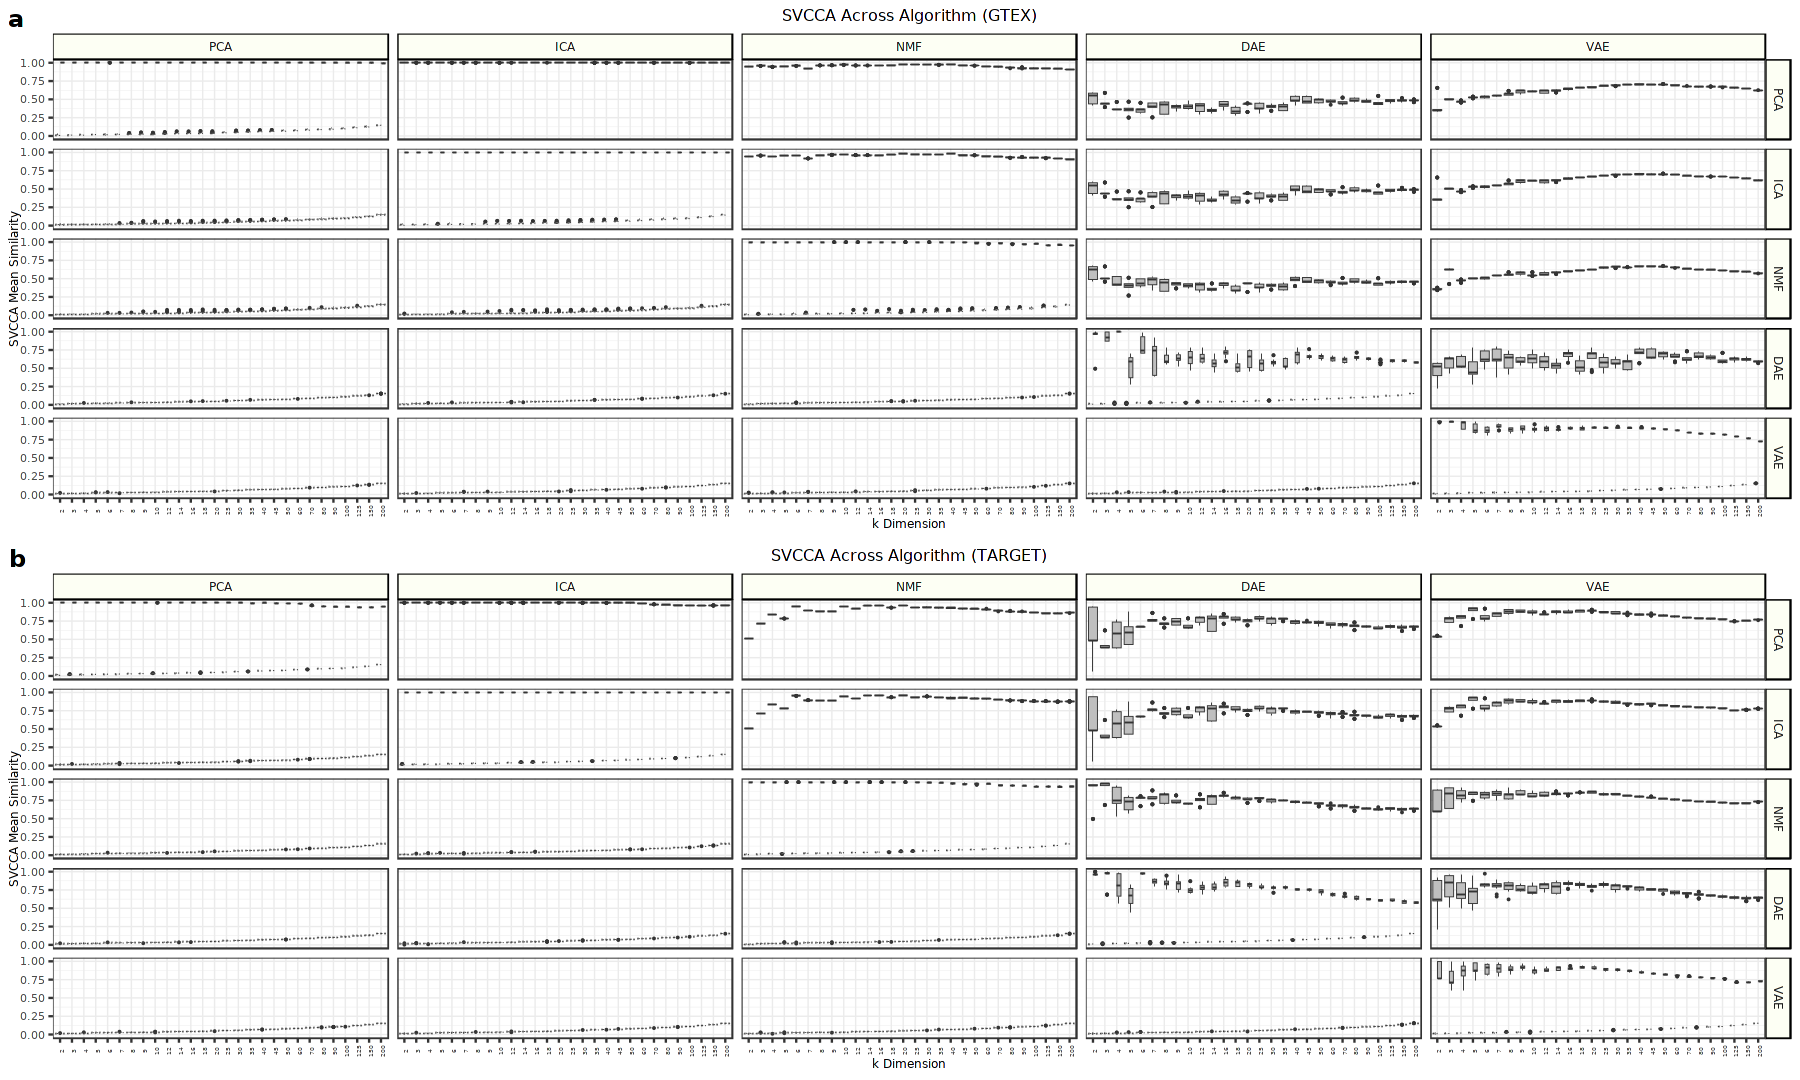

In [42]:
main_plot <- (
    cowplot::plot_grid(
        gtex_across_gg,
        target_across_gg,
        labels = c("a", "b"),
        ncol = 1,
        nrow = 2
    )
)

main_plot

In [43]:
for(extension in fig_extensions) {
    fig_file <- paste0("supplementary_stability_across_algorithm_GTEX_TARGET",
                       extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = main_plot,
                       base_height = 200,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}

In [44]:
gtex_z_gg <- across_dimension_plots[["GTEX"]] +
                theme(legend.position = 'none') +
                ggtitle(paste0("SVCCA Across Dimension (GTEX)"))

target_z_gg <- across_dimension_plots[["TARGET"]] +
                    theme(legend.position = 'none') +
                    ggtitle(paste0("SVCCA Across Dimension (TARGET)"))

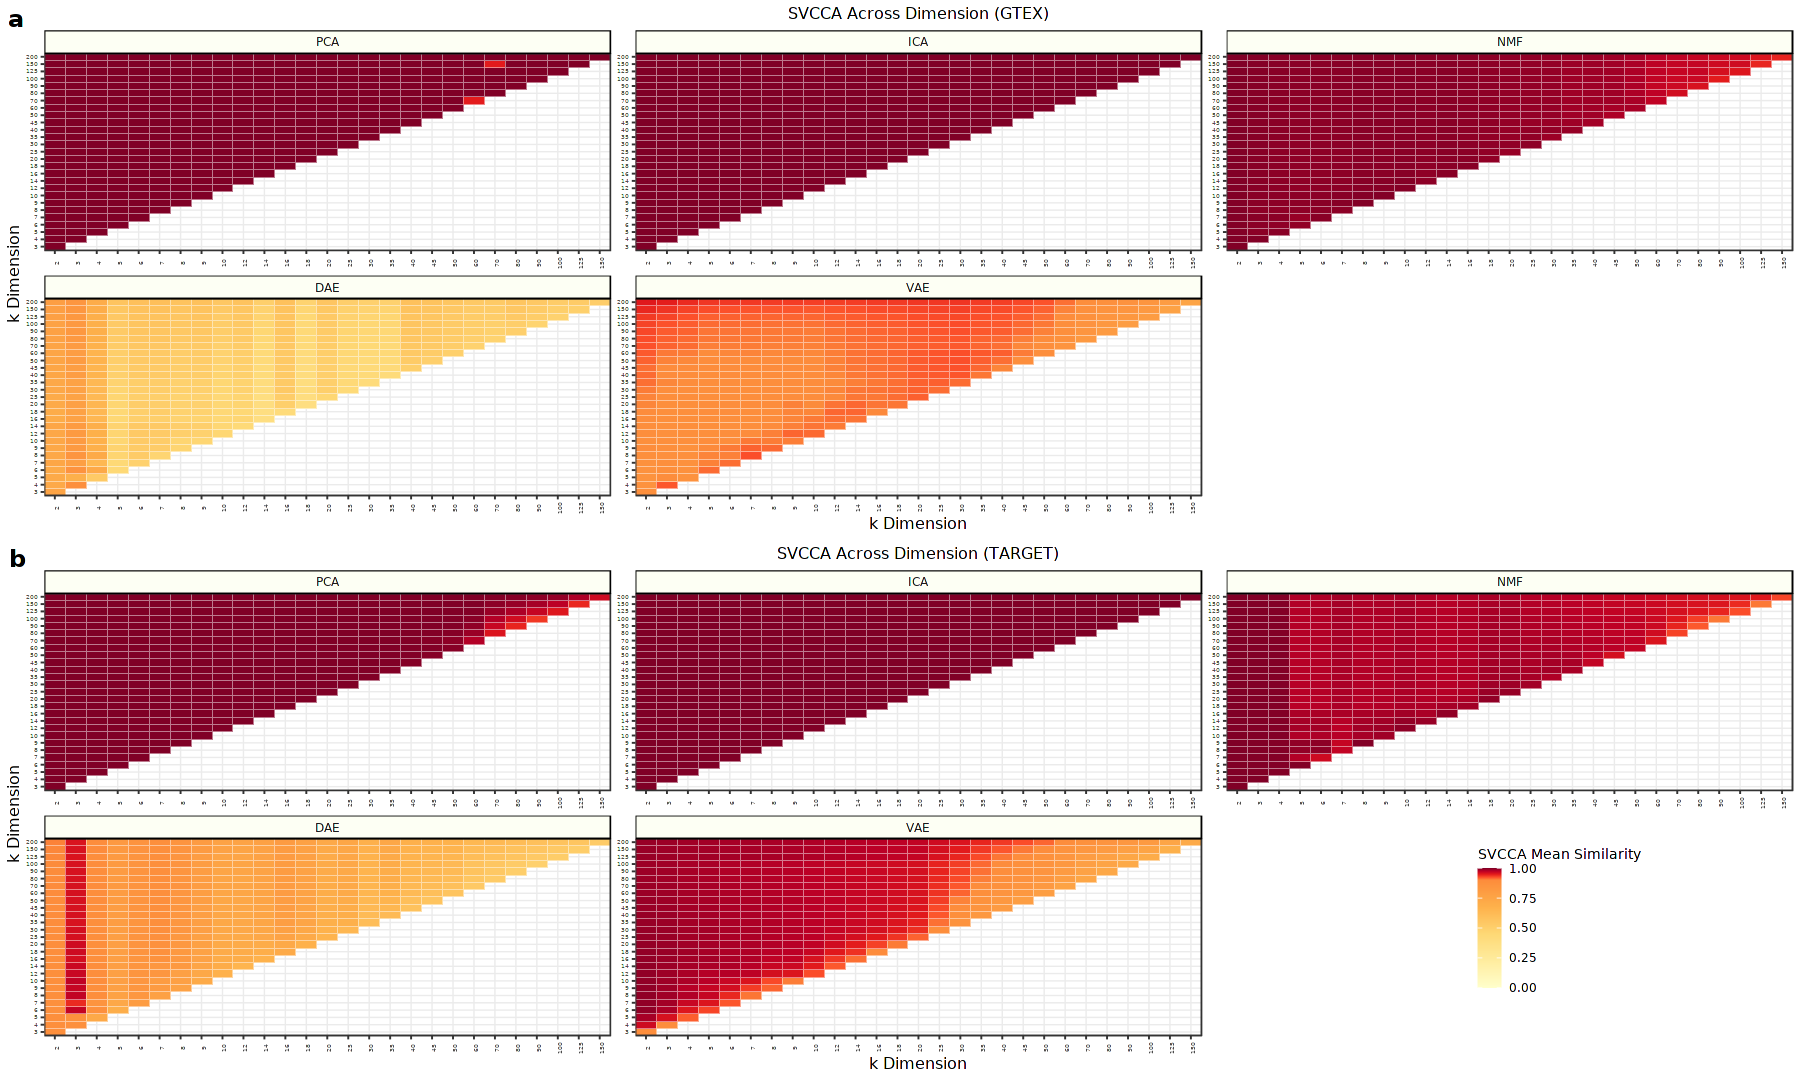

In [45]:
main_plot <- (
    cowplot::plot_grid(
        gtex_z_gg,
        target_z_gg,
        labels = c("a", "b"),
        ncol = 1,
        nrow = 2
    )
)


main_plot <- main_plot + annotation_custom(grob = across_z_legend,
                                           xmin = xmin,
                                           xmax = xmax,
                                           ymin = ymin,
                                           ymax = ymax)

main_plot

In [46]:
for(extension in fig_extensions) {
    fig_file <- paste0("supplementary_stability_across_dimension_GTEX_TARGET",
                       extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = main_plot,
                       base_height = 200,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}